In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
TICK_LABEL_SIZE = 12
AXIS_LABEL_SIZE = 16
AXIS_TITLE_SIZE =  18
LEGEND_FONT_SIZE = 12
FIGURE_TITLE_SIZE = 20

COLORMAP = plt.cm.tab20.colors

DPI = 150

## Load data

In [3]:
data = pd.read_csv("eye_tracking_data.csv")

In [4]:
data.isnull().sum()

ID                                   0
Left eye tracking error degrees      0
Right eye tracking error degrees     0
Age years                            0
Inter pupillary distance mm          0
Gender                               0
Eye colour                           0
Skin tone                            0
Ethnic background                    0
Makeup                               0
Dominant eye                         1
Eyewear type                         0
Eyewear lens type                    0
Eyewear frame type                   0
Eyewear frame thickness              0
Eyewear lens height                  0
Eyewear coating anti-reflective     44
Eyewear coating anti-scratch        48
Eyewear coating anti-fog            83
Eyewear coating anti-UV             77
Eyewear coating anti-smudge         80
Eyewear coating blue-filter         72
dtype: int64

In [5]:
attributes = data.columns.to_list()[3:]

numerical_attributes = data[attributes].select_dtypes(include="number").columns.to_list()

categorical_attributes = data[attributes].select_dtypes(include="object").columns.to_list()

assert len(attributes) == (len(numerical_attributes) + len(categorical_attributes)), "Error!"

In [6]:
LEFT_EYE, RIGHT_EYE = 0, 1
errors = ["Left eye tracking error degrees", "Right eye tracking error degrees"]

## Data Processing and Cleaning

In [7]:
for attribute in categorical_attributes:
    print(f"{attribute}:\n{data[attribute].unique()}\n")

Gender:
['male' 'female' 'Female' 'Male' 'male ']

Eye colour:
['green' 'blue' 'gray-green' 'brown' 'blue-gray' 'blue-gray-green' 'black'
 'dark brown' 'green-brown' 'Black' 'Brown' 'blue-green' 'grey'
 'greengray' 'green/brown' 'hazel brown' 'black/dark brown' 'gray'
 'dark grey' 'green blue' 'Blue' 'green ' 'Grey' 'Green' 'Dark brown'
 'blue-grey' 'Dark grey' 'Blue/Grey' 'blue/green' 'grey/green' 'gray-blue'
 'greenish brown' 'yellow-green-brown']

Skin tone:
['medium' 'dark' 'light' 'Medium' 'Light' 'right' 'Dark']

Ethnic background:
['Europe' 'europe' 'Horn & Sub-Saharan Africa' 'South Asia' 'East Asia'
 'South Asia ' 'Middle-East' 'North Africa' 'Horn & Sub-Saharan Africa.'
 'south Asia' 'east Asia' 'South- Asia ' 'EUrope'
 'Horn and Sub Saharan Africa' 'Middle East']

Makeup:
['no makeup' 'light eye makeup' 'No makeup' 'light makeup'
 'eyelash extensions' 'light eye-makeup']

Dominant eye:
['right' 'left' nan 'Right']

Eyewear type:
['Eyeglasses' 'No-eyewear' 'Contacts']

Eyewea

* Gender

In [8]:
data["Gender"] = data["Gender"].apply(lambda gender: gender.strip().lower())

* Eye colour

In [9]:
def color_formatter(color_string: str) -> str:
    """
    Normalizes and unifies the color naming rules
    by sorting colors, which are part of the input color string, in an ascending order
    and using '-' and '/' as separators.
    """
    color_list = [sub.split("-") for sub in color_string.split("/")]
    color_list = sorted(list(map(sorted, color_list)))
    color_list = list(map("-".join, color_list))

    return "/".join(color_list)


data["Eye colour"] = data["Eye colour"].apply(lambda color: color.strip().lower())\
                                       .apply(lambda color: color.replace("grey", "gray"))\
                                       .apply(lambda color: color.replace("greengray", "green-gray"))\
                                       .apply(lambda color: color.replace("ish", ""))\
                                       .apply(lambda color: "-".join(color.split()))\
                                       .apply(color_formatter)

* Skin tone

In [10]:
data["Skin tone"] = data["Skin tone"].apply(lambda skin_tone: skin_tone.strip().lower())\
                                     .apply(lambda skin_tone: skin_tone.replace("right", "light"))

* Ethnic background

In [11]:
def background_formatter(background_string: str) -> str:
    """
    Normalizes the formatting of the input background string
    by ensuring that all the name subparts are capitalized and seperated by '-'.
    """
    background_list = [sub.strip("-. ").split("-") for sub in background_string.split()]
    return "-".join([s.strip("-. ").lower().capitalize() for sub in background_list for s in sub])


data["Ethnic background"] = data["Ethnic background"].apply(lambda bkg: bkg.strip(". "))\
                                                     .apply(background_formatter)\
                                                     .apply(lambda bkg: bkg.replace("&", "And"))

* Makeup

In [12]:
data["Makeup"] = data["Makeup"].apply(lambda makeup: makeup.strip().lower())\
                               .apply(lambda makeup: makeup.replace("-", " "))

* Dominant eye

In [13]:
data["Dominant eye"] = data["Dominant eye"].apply(lambda eye: eye if eye is np.nan else eye.strip().lower())

* Eye tracking error

In [14]:
data[errors].describe()

,Left eye tracking error degrees,Right eye tracking error degrees
count,232.000000,232.000000
mean,1.082688,1.095334
std,0.783310,0.729386
min,0.360193,0.393180
25%,0.693612,0.702833
50%,0.930610,0.930837
75%,1.221064,1.217110
max,9.491375,6.394730


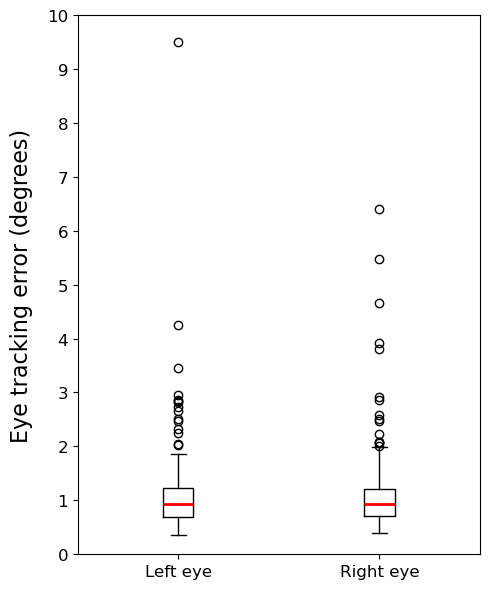

In [15]:
fig, ax = plt.subplots(figsize=(5, 6), layout="tight")

ax.boxplot(
    [data[errors[LEFT_EYE]], data[errors[RIGHT_EYE]]],
    medianprops={"linewidth": 2, "color": "red"},
)

ax.set_ylim(0, 10)
ax.set_yticks(np.linspace(0, 10, 11))
ax.set_yticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=TICK_LABEL_SIZE)
ax.set_ylabel("Eye tracking error (degrees)", fontsize=AXIS_LABEL_SIZE, labelpad=10)

ax.set_xticklabels(["Left eye", "Right eye"], fontsize=TICK_LABEL_SIZE);

fig.savefig("media/eye-tracking-error-boxplot.png", dpi=DPI)

In [16]:
error_condition = (data[errors[LEFT_EYE]] < 8) & (data[errors[RIGHT_EYE]] < 8)

data = data[error_condition]

## Data Visualization and Analysis

In [17]:
from scipy import stats


def ci_95(x):
    """
    Computes the 95% confidence interval of the mean of the input sample x.
    """
    if len(x) < 5: return None
    
    se = x.std() / np.sqrt(len(x)) # standard error
    df = len(x) - 1 # degrees of freedom

    cv = stats.t.ppf(1-0.025, df) # confidence level value

    return cv * se


def catplot(
    means,
    ci,
    attribute_name,
    categories,
    axis
):
    """
    """
    axis[0].set_ylim(0, 2.2)
    axis[0].set_yticks(np.linspace(0, 2.2, 12))
    axis[0].set_yticklabels([f"{tick:.1f}" for tick in np.linspace(0, 2.2, 12)], fontsize=TICK_LABEL_SIZE)
    axis[0].set_ylabel("Mean Error (degrees)\nwith 95%-CI", fontsize=AXIS_LABEL_SIZE, labelpad=10)

    BAR_WIDTH = 0.2

    for i, key in enumerate(means):
        ms = [means[key].get(cat, np.nan) for cat in categories]
        cis = [ci[key].get(cat, np.nan) for cat in categories]

        bars = axis[i].bar(
            np.arange(len(categories)) * 2*BAR_WIDTH,
            ms,
            yerr=cis,
            width=BAR_WIDTH,
            tick_label=categories,
            color=[COLORMAP[2*c + 1] for c in range(len(categories))],
            linewidth=1.5,
            edgecolor="black",
            error_kw={"ecolor": "black", "elinewidth": 1.5, "capsize": 4}
        )
        axis[i].bar_label(bars, fmt="%.2f", label_type="center", padding=3.5, fontsize=TICK_LABEL_SIZE)

        axis[i].set_xlabel(attribute_name, fontsize=AXIS_LABEL_SIZE, labelpad=10)
        axis[i].set_title(" ".join(key.split()[:2]), fontsize=AXIS_TITLE_SIZE, pad=15)

    return axis

In [18]:
def kruskal_wallis_test(
    groups: list[np.array],
    alpha: float = 0.05
) -> tuple[float, str]:
    """
    source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal

    Compute the Kruskal-Wallis H-test for independent groups.
    The test works on 2 or more independent groups, which may have different sizes.

    H0: the medians of all the groups are equal

    H1: at least one median of one group is different from the median of at least one other group

    Returns:
    -------
    pvalue: float
        the p-value for the test using the assumption that H has a chi square distribution

    res: str
        the test outcome saying whether to reject H0 given the significance level (alpha)
    
    """
    if len(groups) < 2: return (np.nan, f"Test cannot be computed! The number of input groups must be at least 2.")
    
    pvalue = stats.kruskal(*groups).pvalue
    res = "reject H0" if pvalue < alpha else "fail to reject H0"

    return (pvalue, res)

## 1. Makeup

In [19]:
attribute_name = "is_makeup"

data[attribute_name] = (data["Makeup"] != "no makeup").map({True: "Yes", False: "No"})

data[attribute_name].value_counts()

is_makeup
No     204
Yes     27
Name: count, dtype: int64

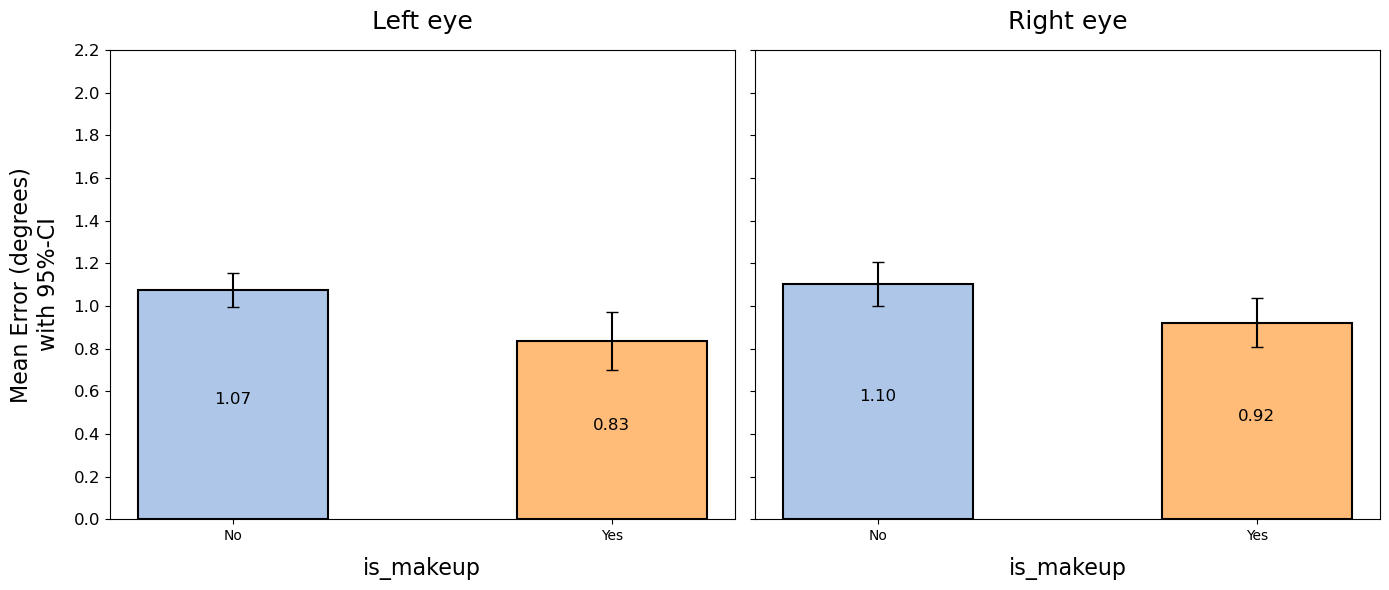

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, layout="tight")

_ = catplot(
    data.groupby(by=attribute_name)[errors].mean().to_dict(),
    data.groupby(by=attribute_name)[errors].apply(ci_95).to_dict(),
    attribute_name,
    categories=data[attribute_name].unique(),
    axis=ax                 
)
fig.savefig("media/is-makeup-barplot.png", dpi=DPI)

Kruskal–Wallis test

In [21]:
for error in errors:
    groups = [data[data[attribute_name] == cat][error].to_numpy() for cat in data[attribute_name].unique()]
    groups = [g for g in groups if len(g) >=5]

    pvalue, res = kruskal_wallis_test(groups)
    print(f"{error}: {res}, pvalue = {pvalue:.3f}\n")

Left eye tracking error degrees: reject H0, pvalue = 0.022

Right eye tracking error degrees: fail to reject H0, pvalue = 0.447



In [22]:
attribute_name = "Makeup"

data[attribute_name].value_counts()

Makeup
no makeup             204
light eye makeup       22
eyelash extensions      3
light makeup            2
Name: count, dtype: int64

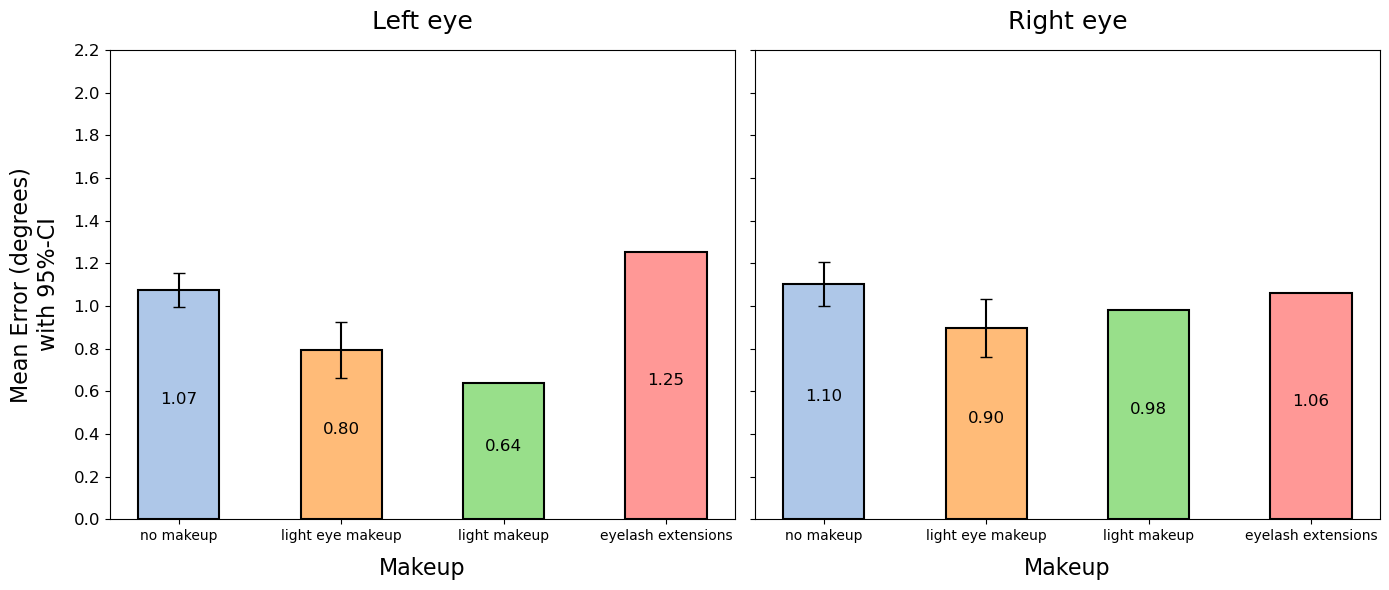

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, layout="tight")

_ = catplot(
    data.groupby(by=attribute_name)[errors].mean().to_dict(),
    data.groupby(by=attribute_name)[errors].apply(ci_95).to_dict(),
    attribute_name,
    categories=data[attribute_name].unique(),
    axis=ax                 
)
fig.savefig("media/makeup-barplot.png", dpi=DPI)

Kruskal–Wallis test

In [24]:
for error in errors:
    groups = [data[data[attribute_name] == cat][error].to_numpy() for cat in data[attribute_name].unique()]
    groups = [g for g in groups if len(g) >=5]

    pvalue, res = kruskal_wallis_test(groups)
    print(f"{error}: {res}, pvalue = {pvalue:.3f}\n")

Left eye tracking error degrees: reject H0, pvalue = 0.010

Right eye tracking error degrees: fail to reject H0, pvalue = 0.259



## 2. Eyewear type

In [25]:
attribute_name = "is_eyewear"

data["is_eyewear"] = (data["Eyewear type"] != "No-eyewear").map({True: "Yes", False: "No"})

data[attribute_name].value_counts()

is_eyewear
No     124
Yes    107
Name: count, dtype: int64

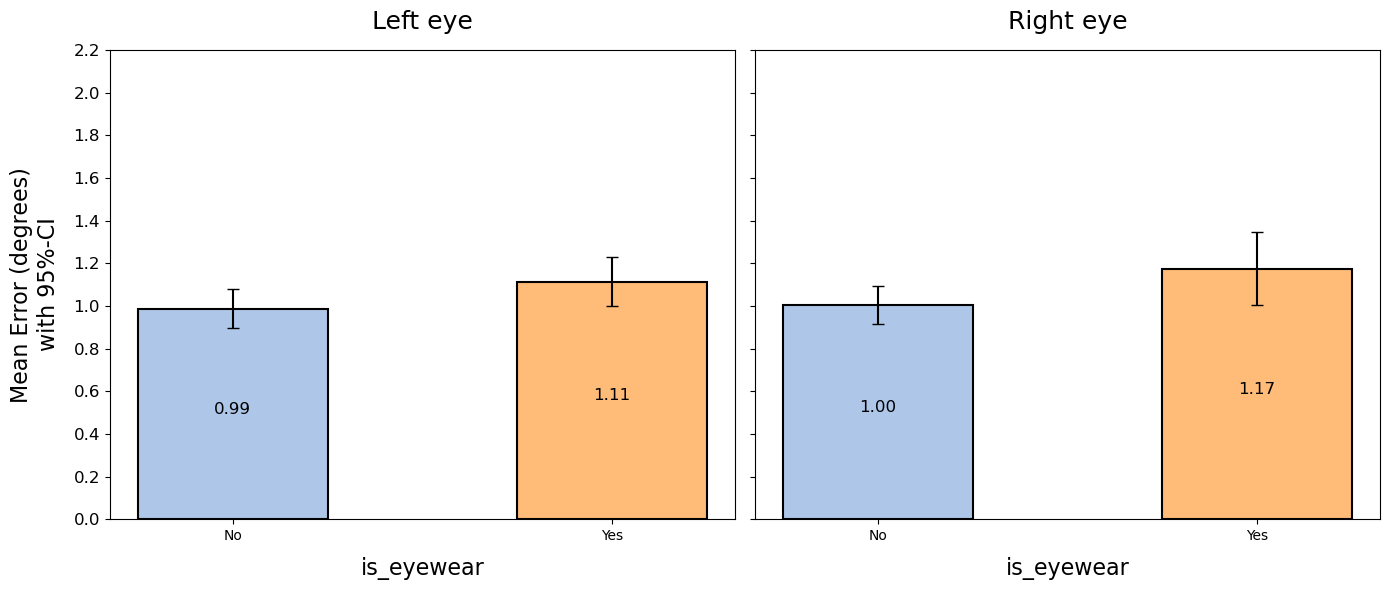

In [26]:
categories = ["No", "Yes"]

fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, layout="tight")

_ = catplot(
    data.groupby(by=attribute_name)[errors].mean().to_dict(),
    data.groupby(by=attribute_name)[errors].apply(ci_95).to_dict(),
    attribute_name,
    categories=categories,
    axis=ax                 
)
fig.savefig("media/is-eyewear-barplot.png", dpi=DPI)

Kruskal–Wallis test

In [27]:
for error in errors:
    groups = [data[data[attribute_name] == cat][error].to_numpy() for cat in categories]
    groups = [g for g in groups if len(g) >=5]

    pvalue, res = kruskal_wallis_test(groups)
    print(f"{error}: {res}, pvalue = {pvalue:.3f}\n")

Left eye tracking error degrees: fail to reject H0, pvalue = 0.176

Right eye tracking error degrees: fail to reject H0, pvalue = 0.141



In [28]:
attribute_name = "Eyewear type"
data[attribute_name].value_counts()

Eyewear type
No-eyewear    124
Eyeglasses     91
Contacts       16
Name: count, dtype: int64

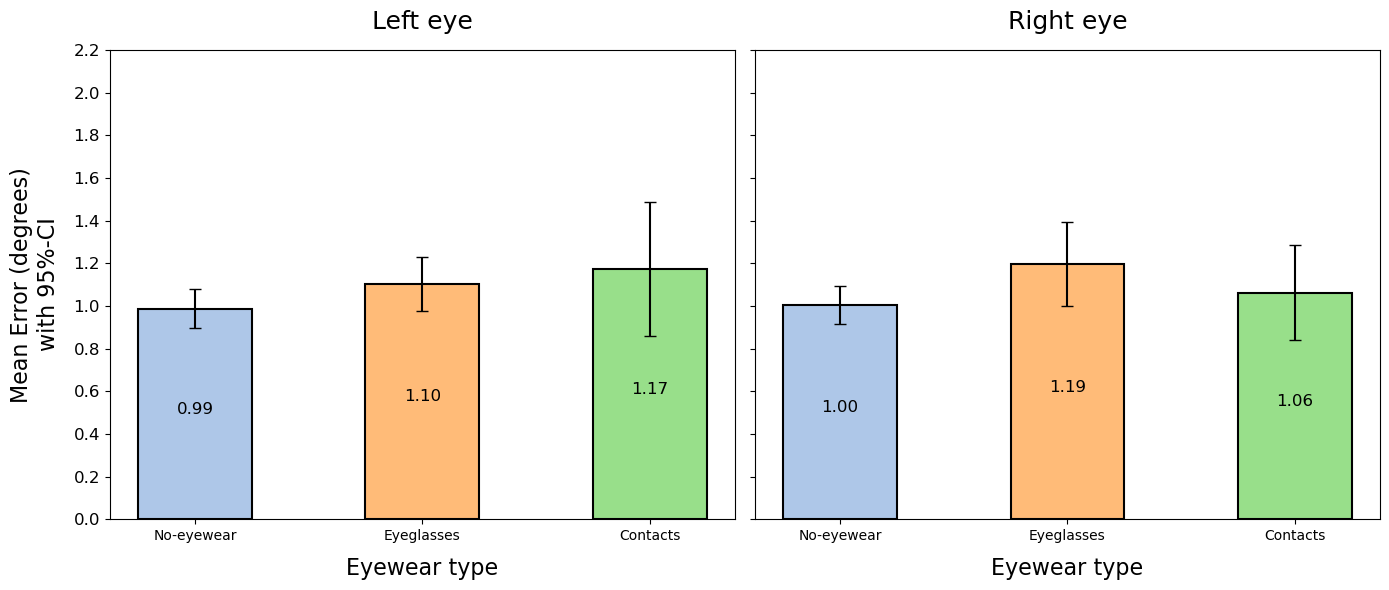

In [29]:
categories = data[attribute_name].value_counts().index

fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, layout="tight")

_ = catplot(
    data.groupby(by=attribute_name)[errors].mean().to_dict(),
    data.groupby(by=attribute_name)[errors].apply(ci_95).to_dict(),
    attribute_name,
    categories=categories,
    axis=ax                 
)
fig.savefig("media/eyewear-type-barplot.png", dpi=DPI)

Kruskal–Wallis test

In [30]:
for error in errors:
    groups = [data[data[attribute_name] == cat][error].to_numpy() for cat in categories]
    groups = [g for g in groups if len(g) >=5]

    pvalue, res = kruskal_wallis_test(groups)
    print(f"{error}: {res}, pvalue = {pvalue:.3f}\n")

Left eye tracking error degrees: fail to reject H0, pvalue = 0.320

Right eye tracking error degrees: fail to reject H0, pvalue = 0.321



## 3. Eyewear frame type

In [31]:
attribute_name = "Eyewear frame type"
data[attribute_name].value_counts()

Eyewear frame type
No-eyewear      124
Full             78
Contacts         16
Semi-rimless     10
Rimless           3
Name: count, dtype: int64

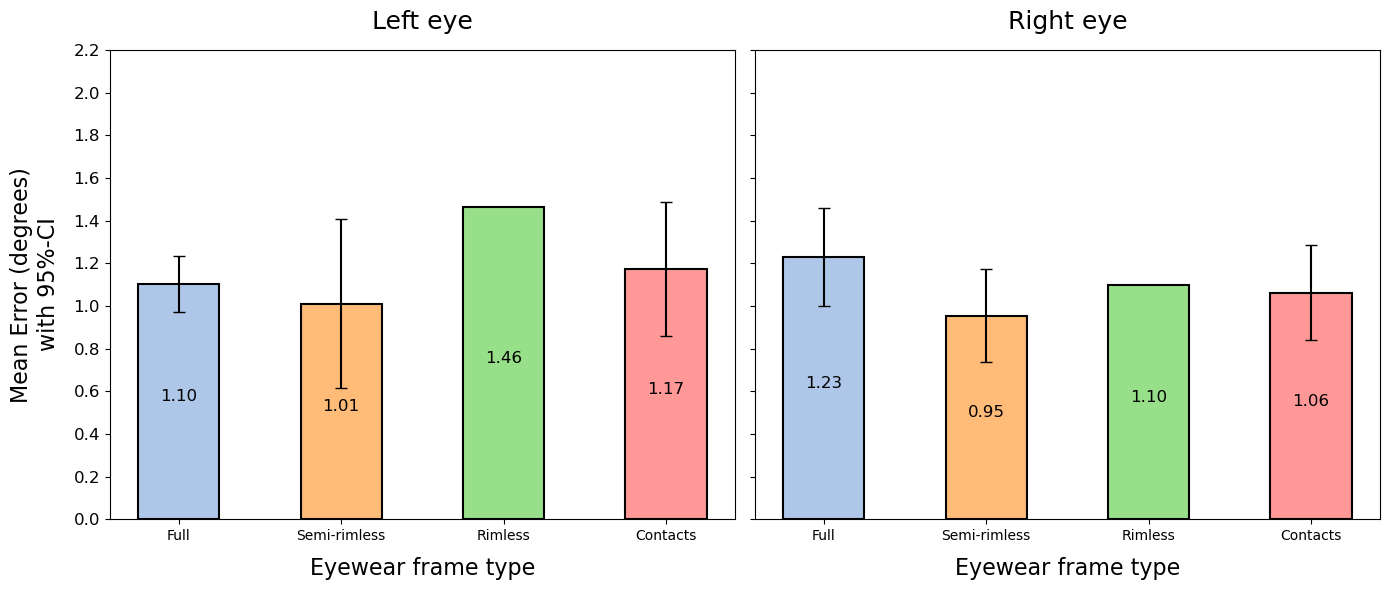

In [32]:
categories = ["Full", "Semi-rimless", "Rimless", "Contacts"]

fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, layout="tight")

_ = catplot(
    data.groupby(by=attribute_name)[errors].mean().to_dict(),
    data.groupby(by=attribute_name)[errors].apply(ci_95).to_dict(),
    attribute_name,
    categories=categories,
    axis=ax                 
)
fig.savefig("media/eyewear-frame-type-barplot.png", dpi=DPI)

Kruskal–Wallis test

In [33]:
for error in errors:
    groups = [data[data[attribute_name] == cat][error].to_numpy() for cat in categories]
    groups = [g for g in groups if len(g) >=5]

    pvalue, res = kruskal_wallis_test(groups)
    print(f"{error}: {res}, pvalue = {pvalue:.3f}\n")

Left eye tracking error degrees: fail to reject H0, pvalue = 0.729

Right eye tracking error degrees: fail to reject H0, pvalue = 0.777



## 4. Eyewear frame thickness

In [34]:
attribute_name = "Eyewear frame thickness"
data[attribute_name].value_counts()

Eyewear frame thickness
No-eyewear    124
Medium         43
Narrow         32
Contacts       16
Thick          13
No-frame        3
Name: count, dtype: int64

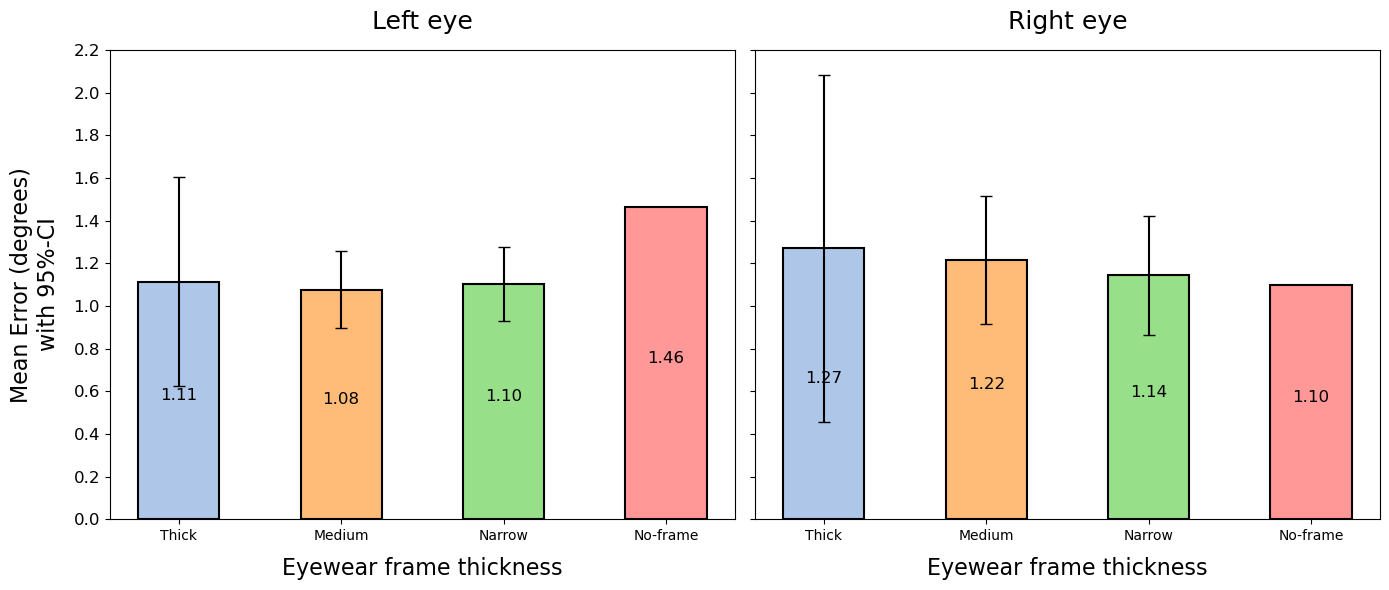

In [35]:
categories = ["Thick", "Medium", "Narrow", "No-frame"]

fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, layout="tight")

_ = catplot(
    data.groupby(by=attribute_name)[errors].mean().to_dict(),
    data.groupby(by=attribute_name)[errors].apply(ci_95).to_dict(),
    attribute_name,
    categories=categories,
    axis=ax                 
)
fig.savefig("media/eyewear-frame-thickness-barplot.png", dpi=DPI)

Kruskal–Wallis test

In [36]:
for error in errors:
    groups = [data[data[attribute_name] == cat][error].to_numpy() for cat in categories]
    groups = [g for g in groups if len(g) >=5]

    pvalue, res = kruskal_wallis_test(groups)
    print(f"{error}: {res}, pvalue = {pvalue:.3f}\n")

Left eye tracking error degrees: fail to reject H0, pvalue = 0.538

Right eye tracking error degrees: fail to reject H0, pvalue = 0.716



## 5. Eyewear lens type

In [37]:
attribute_name = "Eyewear lens type"
data[attribute_name].value_counts()

Eyewear lens type
No-eyewear       124
Single-vision     70
Bifocals          20
Contacts          16
Trifocal           1
Name: count, dtype: int64

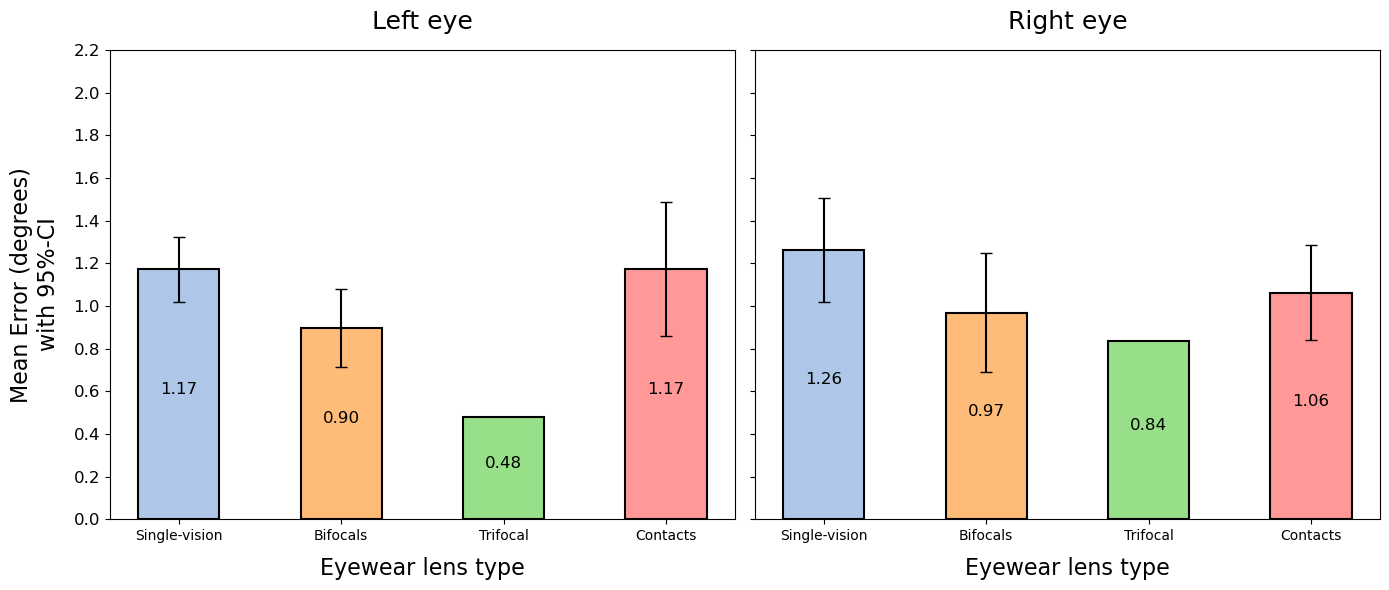

In [38]:
categories = ["Single-vision", "Bifocals", "Trifocal", "Contacts"]

fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, layout="tight")

_ = catplot(
    data.groupby(by=attribute_name)[errors].mean().to_dict(),
    data.groupby(by=attribute_name)[errors].apply(ci_95).to_dict(),
    attribute_name,
    categories=categories,
    axis=ax                 
)
fig.savefig("media/eyewear-lens-type-barplot.png", dpi=DPI)

Kruskal–Wallis test

In [39]:
for error in errors:
    groups = [data[data[attribute_name] == cat][error].to_numpy() for cat in categories]
    groups = [g for g in groups if len(g) >=5]

    pvalue, res = kruskal_wallis_test(groups)
    print(f"{error}: {res}, pvalue = {pvalue:.3f}\n")

Left eye tracking error degrees: fail to reject H0, pvalue = 0.132

Right eye tracking error degrees: fail to reject H0, pvalue = 0.160



## 6. Eyewear lens height

In [40]:
attribute_name = "Eyewear lens height"
data[attribute_name].value_counts()

Eyewear lens height
No-eyewear    124
Normal         54
Low            26
Contacts       16
High           11
Name: count, dtype: int64

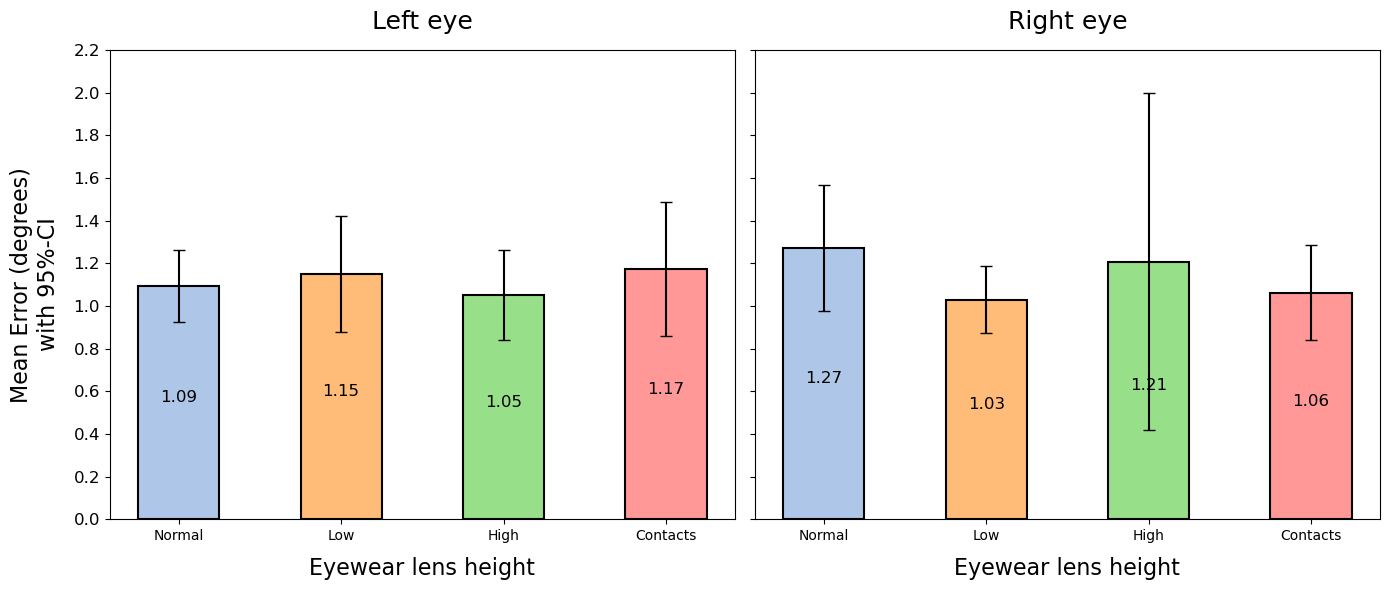

In [41]:
categories = ["Normal", "Low", "High", "Contacts"]

fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, layout="tight")

_ = catplot(
    data.groupby(by=attribute_name)[errors].mean().to_dict(),
    data.groupby(by=attribute_name)[errors].apply(ci_95).to_dict(),
    attribute_name,
    categories=categories,
    axis=ax                 
)
fig.savefig("media/eyewear-lens-height-barplot.png", dpi=DPI)

Kruskal–Wallis test

In [42]:
for error in errors:
    groups = [data[data[attribute_name] == cat][error].to_numpy() for cat in categories]
    groups = [g for g in groups if len(g) >=5]

    pvalue, res = kruskal_wallis_test(groups)
    print(f"{error}: {res}, pvalue = {pvalue:.3f}\n")

Left eye tracking error degrees: fail to reject H0, pvalue = 0.827

Right eye tracking error degrees: fail to reject H0, pvalue = 0.912



## 7. Eyewear coating type

In [43]:
eyewear_coating_types = [
    "Eyewear coating anti-reflective",
    "Eyewear coating anti-scratch",
    "Eyewear coating anti-fog",
    "Eyewear coating anti-UV",
    "Eyewear coating anti-smudge",
    "Eyewear coating blue-filter"
]

In [44]:
for attribute_name in eyewear_coating_types:
    d = data[~data[attribute_name].isnull()]
    print(d[attribute_name].value_counts())
    print()

Eyewear coating anti-reflective
No-eyewear    124
Yes            39
No             24
Name: count, dtype: int64

Eyewear coating anti-scratch
No-eyewear    124
Yes            34
No             25
Name: count, dtype: int64

Eyewear coating anti-fog
No-eyewear    124
No             24
Name: count, dtype: int64

Eyewear coating anti-UV
No-eyewear    124
No             24
Yes             7
Name: count, dtype: int64

Eyewear coating anti-smudge
No-eyewear    124
No             24
Yes             3
Name: count, dtype: int64

Eyewear coating blue-filter
No-eyewear    124
No             24
Yes            12
Name: count, dtype: int64



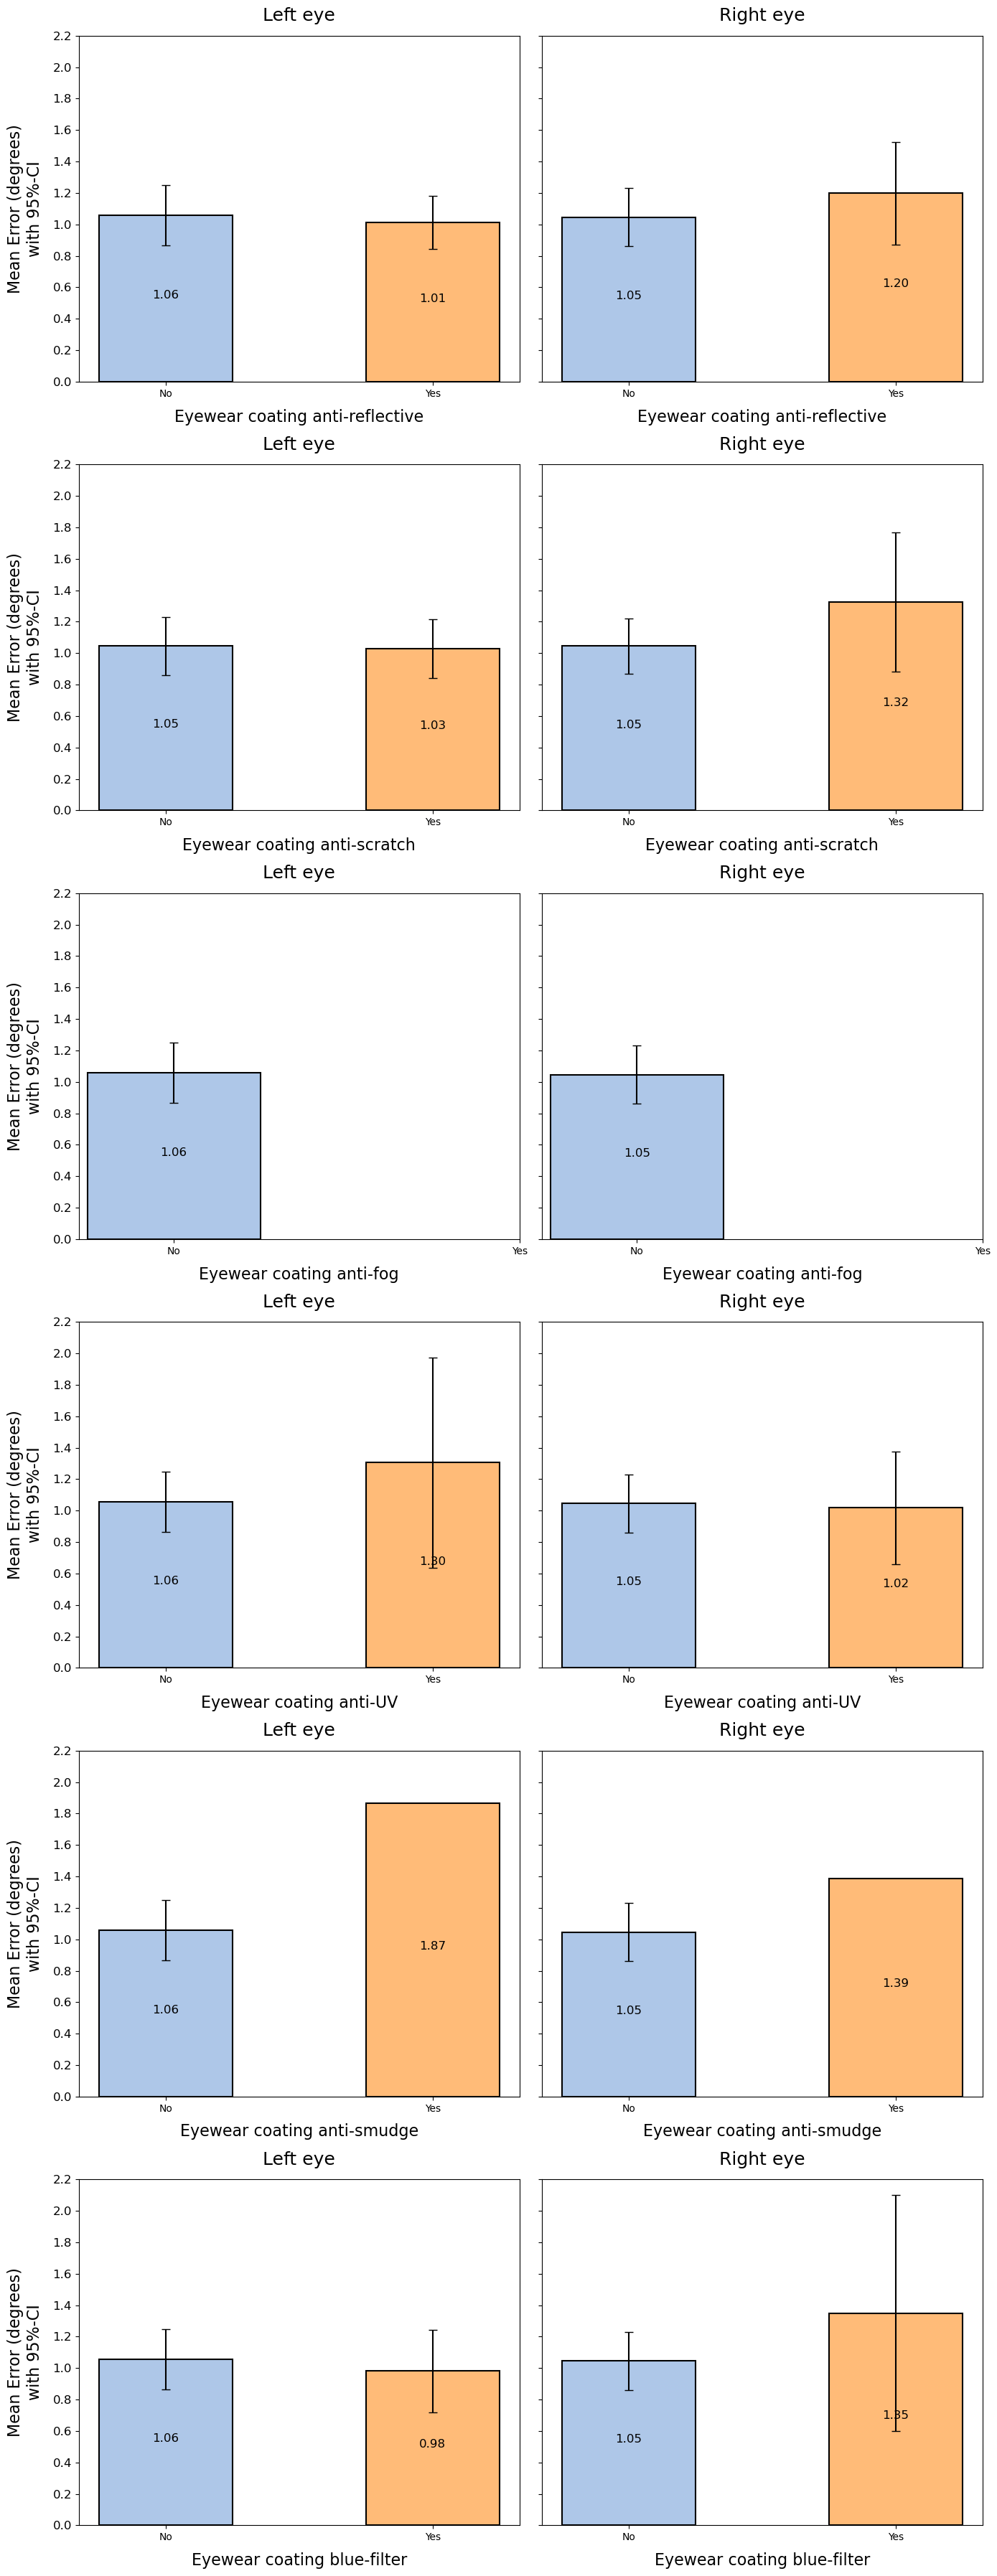

In [45]:
fig, ax = plt.subplots(len(eyewear_coating_types), 2, figsize=(14, len(eyewear_coating_types) * 6), sharey=True, layout="tight")

for idx, attribute_name in enumerate(eyewear_coating_types):
    _ = catplot(
        data[~data[attribute_name].isnull()].groupby(by=attribute_name)[errors].mean().to_dict(),
        data[~data[attribute_name].isnull()].groupby(by=attribute_name)[errors].apply(ci_95).to_dict(),
        attribute_name,
        categories=["No", "Yes"],
        axis=ax[idx]
    )

fig.savefig("media/eyewear-coating-type-barplot.png", dpi=DPI)

Kruskal–Wallis test

In [46]:
for attribute_name in eyewear_coating_types:
    print(f"\n-{attribute_name}-")

    d = data[~data[attribute_name].isnull()]

    for error in errors:
        groups = [d[d[attribute_name] == cat][error].to_numpy() for cat in ("No", "Yes")]
        groups = [g for g in groups if len(g) >=5]

        pvalue, res = kruskal_wallis_test(groups)
        print(f"{error}: {res}, pvalue = {pvalue:.3f}\n")


-Eyewear coating anti-reflective-
Left eye tracking error degrees: fail to reject H0, pvalue = 0.396

Right eye tracking error degrees: fail to reject H0, pvalue = 0.910


-Eyewear coating anti-scratch-
Left eye tracking error degrees: fail to reject H0, pvalue = 0.581

Right eye tracking error degrees: fail to reject H0, pvalue = 0.988


-Eyewear coating anti-fog-
Left eye tracking error degrees: Test cannot be computed! The number of input groups must be at least 2., pvalue = nan

Right eye tracking error degrees: Test cannot be computed! The number of input groups must be at least 2., pvalue = nan


-Eyewear coating anti-UV-
Left eye tracking error degrees: fail to reject H0, pvalue = 0.422

Right eye tracking error degrees: fail to reject H0, pvalue = 0.925


-Eyewear coating anti-smudge-
Left eye tracking error degrees: Test cannot be computed! The number of input groups must be at least 2., pvalue = nan

Right eye tracking error degrees: Test cannot be computed! The number of in

## 8. Dominant Eye

In [47]:
attribute_name = "Dominant eye"
data[attribute_name].value_counts()

Dominant eye
right    154
left      76
Name: count, dtype: int64

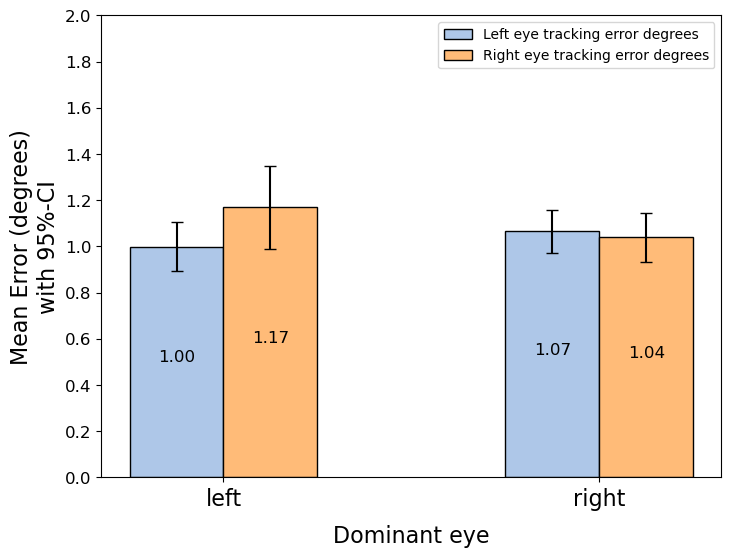

In [48]:
means = data[~data[attribute_name].isnull()].groupby(by=attribute_name)[errors].mean().to_dict()
ci = data[~data[attribute_name].isnull()].groupby(by=attribute_name)[errors].apply(ci_95).to_dict()

categories = ["left", "right"]
x = np.arange(len(categories))

width = 0.25
multiplier = 0
colors = dict(zip(means.keys(), [COLORMAP[1], COLORMAP[3]]))

fig, ax = plt.subplots(figsize=(8, 6))

for attrib, errs in means.items():
    offset = width * multiplier
    bars = ax.bar(
        x + offset,
        errs.values(),
        yerr=ci[attrib].values(),
        capsize=4.,
        width=width,
        align="edge",
        edgecolor="black",
        color=colors[attrib],
        label=attrib
    )
    ax.bar_label(bars, fmt="%.2f", label_type="center", padding=3.5, fontsize=TICK_LABEL_SIZE)
    multiplier += 1

ax.set_xticks(x + width, categories, fontsize=AXIS_LABEL_SIZE)
ax.set_xlabel(attribute_name, fontsize=AXIS_LABEL_SIZE, labelpad=10)

ax.set_ylim(0, 2)
ax.set_yticks(np.linspace(0, 2, 11))
ax.set_yticklabels([f"{tick:.1f}" for tick in np.linspace(0, 2, 11)], fontsize=TICK_LABEL_SIZE)
ax.set_ylabel("Mean Error (degrees)\nwith 95%-CI", fontsize=AXIS_LABEL_SIZE)

ax.legend();

Kruskal–Wallis test

In [49]:
for error in errors:
    d = data[~data[attribute_name].isnull()]

    groups = [d[d[attribute_name] == cat][error].to_numpy() for cat in categories]
    groups = [g for g in groups if len(g) >=5]

    pvalue, res = kruskal_wallis_test(groups)
    print(f"{error}: {res}, pvalue = {pvalue:.3f}\n")

Left eye tracking error degrees: fail to reject H0, pvalue = 0.622

Right eye tracking error degrees: fail to reject H0, pvalue = 0.074



## 9. Eye colour

In [50]:
attribute_name = "Eye colour"
data[attribute_name].value_counts()

Eye colour
brown                 59
blue                  53
green                 35
blue-gray             21
black                 16
brown-dark            12
blue-green            11
gray                   5
brown-green            4
gray-green             4
brown/green            2
dark-gray              2
blue-gray-green        1
brown-hazel            1
black/brown-dark       1
blue/gray              1
blue/green             1
gray/green             1
brown-green-yellow     1
Name: count, dtype: int64

In [51]:
eye_colors = data[attribute_name].unique()
target_eye_colors = eye_colors[data[attribute_name].value_counts(sort=False) >= 5]

print(target_eye_colors)

['green' 'blue' 'brown' 'blue-gray' 'black' 'brown-dark' 'blue-green'
 'gray']


The group of eye colors where each color has at leat 5 measurements

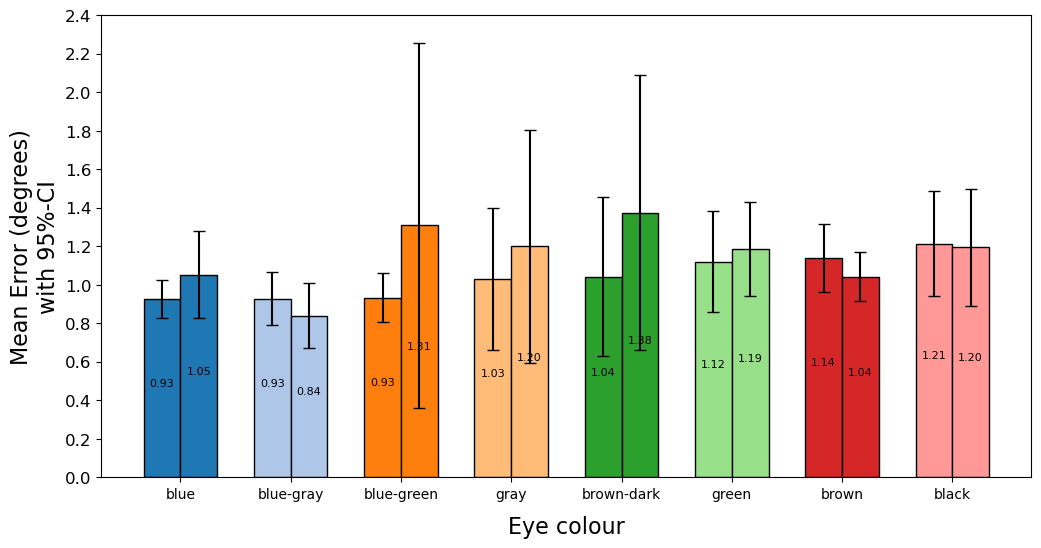

In [52]:
means = data.groupby(by=attribute_name)[errors].mean()
means = means[means.index.isin(target_eye_colors)].sort_values(by=errors).to_dict()

ci = data.groupby(by=attribute_name)[errors].apply(ci_95).to_dict()


categories = means["Left eye tracking error degrees"].keys()

width = 3.
x = np.arange(len(target_eye_colors)) * 3 * width
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 6))

for attrib, errs in means.items():
    offset = width * multiplier
    bars = ax.bar(
        x + offset,
        errs.values(),
        yerr=[ci[attrib][cat] for cat in categories],
        align="edge",
        capsize=4.,
        width=width,
        edgecolor="black",
        color=COLORMAP,
    )
    ax.bar_label(bars, fmt="%.2f", label_type="center", padding=3.5, fontsize=TICK_LABEL_SIZE-4)
    multiplier += 1

ax.set_xticks(x + width, categories, fontsize=10)
ax.set_xlabel(attribute_name, fontsize=AXIS_LABEL_SIZE, labelpad=10)

ax.set_ylim(0, 2.4)
ax.set_yticks(np.linspace(0, 2.4, 13))
ax.set_yticklabels([f"{tick:.1f}" for tick in np.linspace(0, 2.4, 13)], fontsize=TICK_LABEL_SIZE)
ax.set_ylabel("Mean Error (degrees)\nwith 95%-CI", fontsize=AXIS_LABEL_SIZE);

Kruskal–Wallis test

In [53]:
for error in errors:
    groups = [data[data[attribute_name] == cat][error].to_numpy() for cat in categories]
    groups = [g for g in groups if len(g) >=5]

    pvalue, res = kruskal_wallis_test(groups)
    print(f"{error}: {res}, pvalue = {pvalue:.3f}\n")

Left eye tracking error degrees: fail to reject H0, pvalue = 0.522

Right eye tracking error degrees: fail to reject H0, pvalue = 0.237



All eye colors

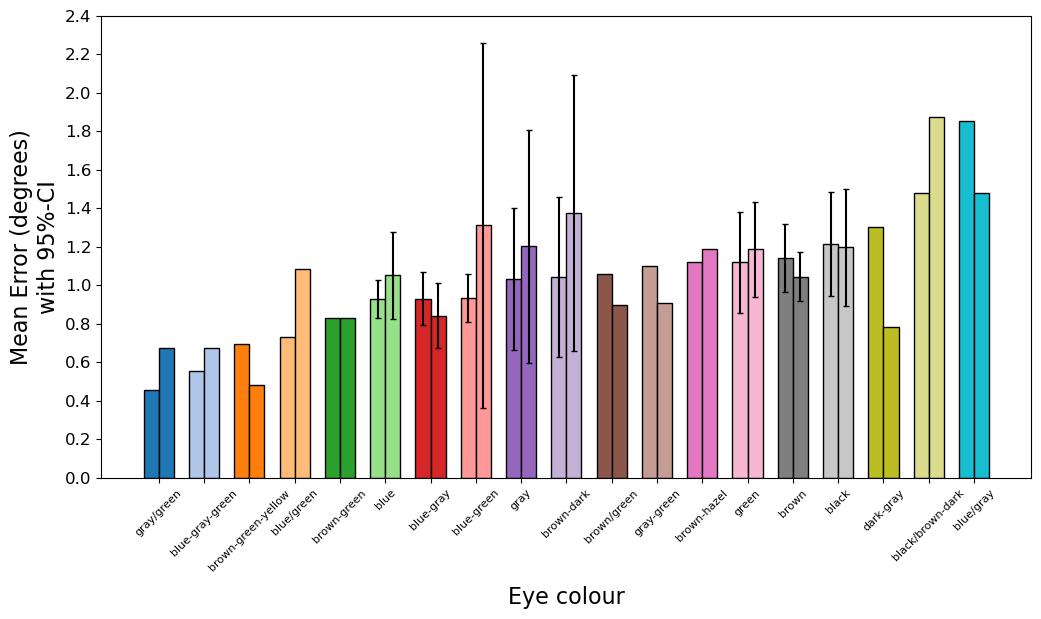

In [54]:
means = data.groupby(by=attribute_name)[errors].mean().sort_values(by=errors).to_dict()
ci = data.groupby(by=attribute_name)[errors].apply(ci_95).to_dict()

categories = means["Left eye tracking error degrees"].keys()

width = 3.
x = np.arange(len(eye_colors)) * 3 * width
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 6))

for attrib, errs in means.items():
    offset = width * multiplier
    bars = ax.bar(
        x + offset,
        errs.values(),
        yerr=[ci[attrib][cat] for cat in categories],
        align="edge",
        capsize=2.,
        width=width,
        edgecolor="black",
        color=COLORMAP,
    )
    multiplier += 1

ax.set_xticks(x + width, categories, fontsize=8, rotation=45)
ax.set_xlabel(attribute_name, fontsize=AXIS_LABEL_SIZE, labelpad=10)

ax.set_ylim(0, 2.4)
ax.set_yticks(np.linspace(0, 2.4, 13))
ax.set_yticklabels([f"{tick:.1f}" for tick in np.linspace(0, 2.4, 13)], fontsize=TICK_LABEL_SIZE)
ax.set_ylabel("Mean Error (degrees)\nwith 95%-CI", fontsize=AXIS_LABEL_SIZE);

## Machine Learning approach to correlation estimation between the eye tracking error and the eyewear physical attributes using Random Forest and permutaton importance of features

based on the following example: https://scikit-learn.org/dev/auto_examples/inspection/plot_permutation_importance.html

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance

In [56]:
features = [
    'Makeup',
    'Eyewear type',
    'Eyewear frame type',
    'Eyewear frame thickness',
    'Eyewear lens type',
    'Eyewear lens height',
]
X = data[features]

In [57]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.set_output(transform="pandas")

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [58]:
X_new = encoder.fit_transform(X)
new_features = X_new.columns

In [59]:
X_new

,Makeup_eyelash extensions,Makeup_light eye makeup,Makeup_light makeup,Makeup_no makeup,Eyewear type_Contacts,Eyewear type_Eyeglasses,Eyewear type_No-eyewear,Eyewear frame type_Contacts,Eyewear frame type_Full,Eyewear frame type_No-eyewear,...,Eyewear lens type_Bifocals,Eyewear lens type_Contacts,Eyewear lens type_No-eyewear,Eyewear lens type_Single-vision,Eyewear lens type_Trifocal,Eyewear lens height_Contacts,Eyewear lens height_High,Eyewear lens height_Low,Eyewear lens height_No-eyewear,Eyewear lens height_Normal
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
228,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
229,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
230,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [60]:
left_eye_error = data[errors[LEFT_EYE]]
right_eye_error = data[errors[RIGHT_EYE]]

In [61]:
result = {}

for target_name, target in zip(errors, [left_eye_error, right_eye_error]):

    target_name = " ".join(target_name.split()[:-1]).lower()
    # fit the model
    model = RandomForestRegressor(random_state=12345)
    model.fit(X_new, target)

    # evaluate the model (r^2)
    r2 = model.score(X_new, target)
    print(f"Model performance on {target_name}: R^2 = {100*r2:.2f}%\n")

    # run the permutation feature importance algorithm
    result[target_name] = permutation_importance(
        model,
        X_new,
        target,
        scoring="r2", # use r^2 scoring metric
        n_repeats=100,
        random_state=12345,
    )

Model performance on left eye tracking error: R^2 = 13.34%

Model performance on right eye tracking error: R^2 = 10.17%



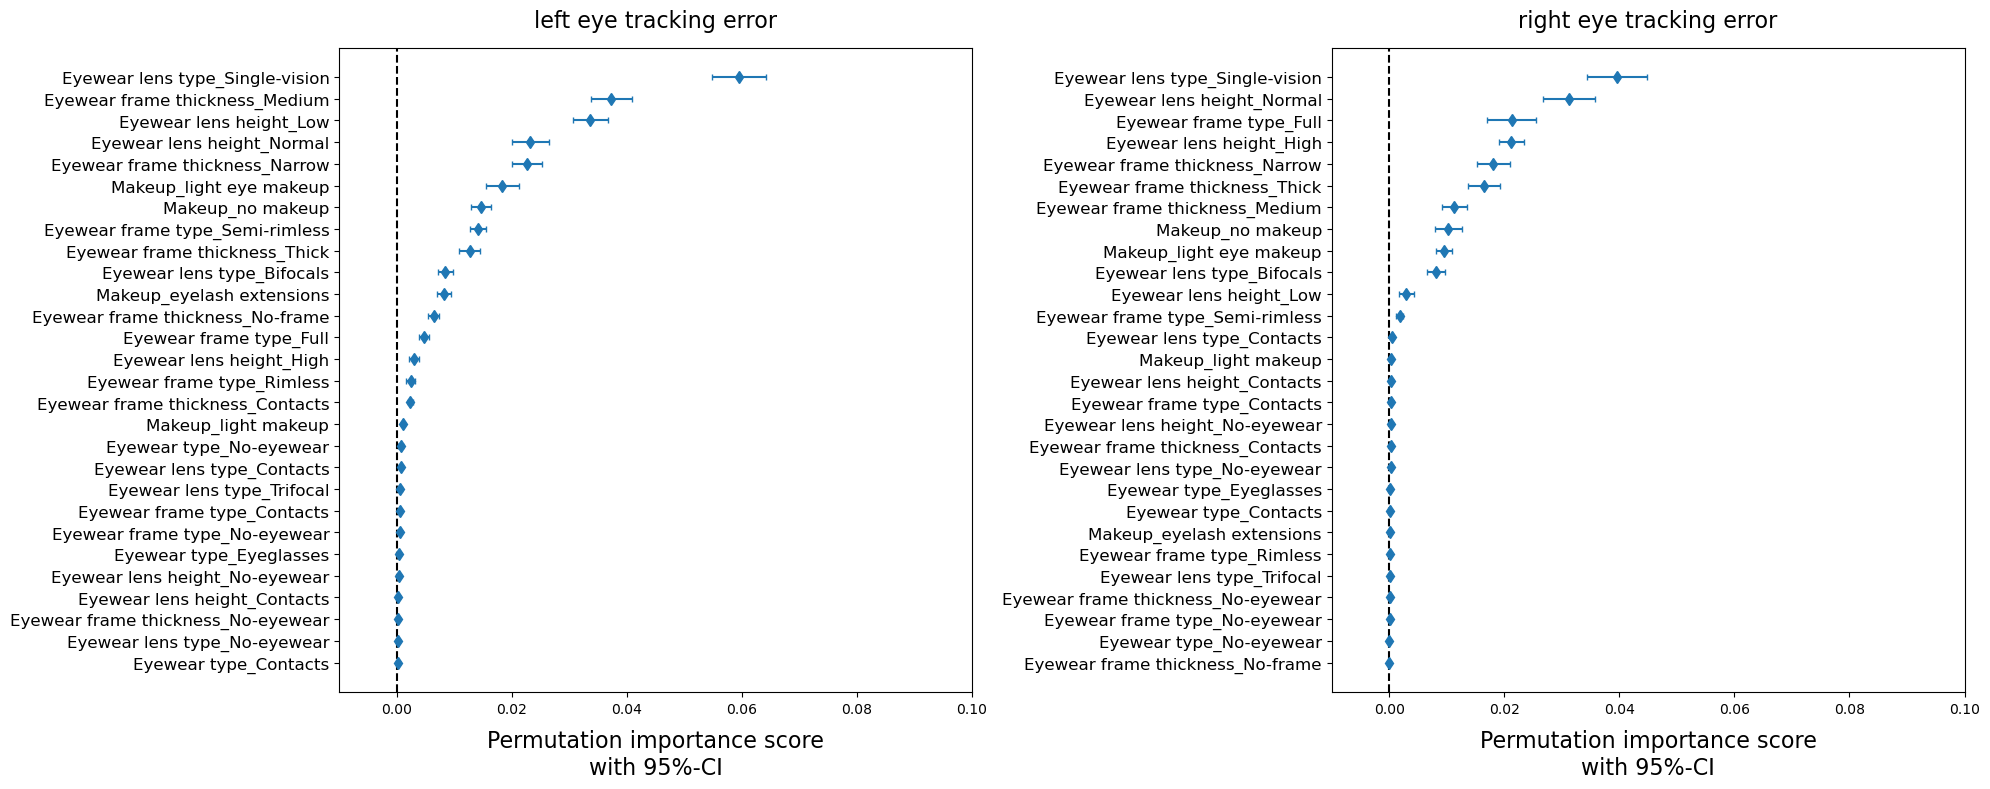

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), layout="tight")

for i, key in enumerate(result):
    sorted_importances_idx = result[key].importances_mean.argsort()
    importances = pd.DataFrame(
        result[key].importances[sorted_importances_idx].T,
        columns=new_features[sorted_importances_idx]
    )
    
    ax[i].errorbar(
        importances.mean(),
        np.arange(28),
        xerr=importances.apply(ci_95),
        fmt="d",
        capsize=2
    )
    ax[i].axvline(x=0, color="k", linestyle="--")

    ax[i].set_yticks(np.arange(len(new_features)))
    ax[i].set_yticklabels(importances.columns, fontsize=TICK_LABEL_SIZE)

    ax[i].set_xlim(-0.01, 0.1)
    ax[i].set_xlabel("Permutation importance score\nwith 95%-CI", fontsize=AXIS_LABEL_SIZE, labelpad=10)
    ax[i].set_title(key, fontsize=AXIS_LABEL_SIZE, pad=15)

fig.savefig("./media/permutation-importance-scores-of-attributes.png", dpi=DPI);